In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 
import torch.nn.functional as F
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from skimage import io

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../figures-datasets/images/corel'
nclasses   = 6

# Set the desired image size for rescaling and maximum value for normalization

width       = 224 
height      = 224
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.40
valid_perc = 0.20
test_perc  = 0.40

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = len(data) - num_train_samples - num_valid_samples 
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

# Set output model name

model_name  = 'CorelViT.pth'

### Create image datasets with some preprocessing: output a list of image tensors

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("\\")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target) 

In [4]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

### Visualize selected images

Number of images: 142

Images are 224x224x3

Class of the image:  6

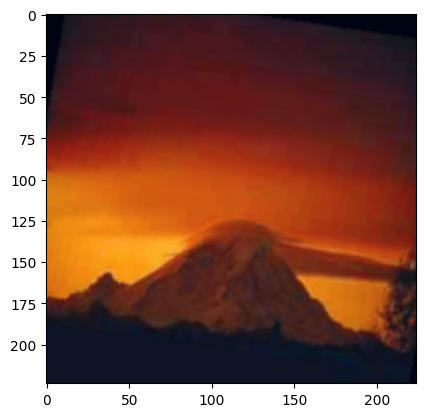

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[100] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Generate batches with batchsize images at random

In [6]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

══════════════════════════════════════════════════════════════════

list of 2 items

Tensor  Shape: torch.Size([32, 3, 224, 224])    Min: -2.118     Max: 2.588      Mean: -0.275    dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([32]) Min: 0.000      Max: 5.000      Mean: 2.562     dtype: torch.int64 @ cpu

══════════════════════════════════════════════════════════════════

### Define classes for patch embedding, transformer encoding, and classification of a Vision Transformer
modified from: https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632 based on 
Attention is All you Need (https://arxiv.org/abs/1706.03762) and the paper https://arxiv.org/pdf/2010.11929.pdf.

### Patch embedding

In [7]:
# It uses https://einops.rocks/ to rearrange tensors

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        # Module that extracts and projects image patches  
        self.projection = nn.Sequential(
            # To improve performance you may use one or multiple conv layers: 
            # Input 32x3x224x224 -> Output 32x768x14x14, for stride=16 and embsize=768
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            # Rearrange the input tensor: Input 32x768x14x14 -> 32x(196)x768
            Rearrange('b c (h) (w) -> b (h w) c'),
        )
        # the cls token is a number assigned to each projected patch
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        # encode the original position of the patches
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        # get batch size in b
        b, _, _, _ = x.shape 
        # project the input
        x = self.projection(x) 
        # repeat the tokens for each image in the batch
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # concatenate the cls tokens to the projected input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

### ViT Encoder

In [8]:
# A multi-head attention means that the Attention Matrix computation is split across n heads 
# with smaller input size.
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, dropout=0):
        super(MultiHeadAttention, self).__init__()
        self.emb_size   = emb_size
        self.num_heads  = num_heads
        self.keys       = nn.Linear(emb_size, emb_size)
        self.queries    = nn.Linear(emb_size, emb_size)
        self.values     = nn.Linear(emb_size, emb_size)
        self.att_drop   = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values into num_heads:
        # the resulting keys, queries, and values have a shape 
        # of BATCH=32, HEADS=8, SEQUENCE_LEN=196, EMBEDDING_SIZE=768
        
        queries         = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys            = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values          = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        
        # To compute the attention matrix, we multiply queries and keys matrices, 
        # and sum up over the last axis, resulting in a vector of shape 
        # (batch, num_heads, query_len, key_len)
        
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) 
        if mask is not None: # create a mask
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        # the attention is finally the softmax 
        # of the resulting vector divided by a scaling factor 
        # based on the size of the embedding.
        
        scaling = self.emb_size ** (1/2)
        att     = F.softmax(energy, dim=-1) / scaling
        att     = self.att_drop(att)
        
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

# We need to create classes for the residual connection and feed forward blocks, 
# which will be used in the encoder.    

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super(ResidualAdd, self).__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super(FeedForwardBlock, self).__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super(TransformerEncoderBlock, self).__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super(TransformerEncoder, self).__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

# Finally, we add the classification head

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 6):
        super(ClassificationHead, self).__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))
        

### ViT model

In [9]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 6,
                **kwargs):
        super(ViT, self).__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

### Create the model

In [10]:
model = ViT()
summary(model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─PatchEmbedding: 1-1                    [-1, 197, 768]            --
|    └─Sequential: 2-1                   [-1, 196, 768]            --
|    |    └─Conv2d: 3-1                  [-1, 768, 14, 14]         590,592
|    |    └─Rearrange: 3-2               [-1, 196, 768]            --
├─TransformerEncoder: 1-2                [-1, 197, 768]            --
|    └─TransformerEncoderBlock: 2-2      [-1, 197, 768]            --
|    |    └─ResidualAdd: 3-3             [-1, 197, 768]            2,363,904
|    |    └─ResidualAdd: 3-4             [-1, 197, 768]            4,723,968
|    └─TransformerEncoderBlock: 2-3      [-1, 197, 768]            --
|    |    └─ResidualAdd: 3-5             [-1, 197, 768]            2,363,904
|    |    └─ResidualAdd: 3-6             [-1, 197, 768]            4,723,968
|    └─TransformerEncoderBlock: 2-4      [-1, 197, 768]            --
|    |    └─ResidualAdd: 3-7             [-1, 197, 7

Layer (type:depth-idx)                   Output Shape              Param #
├─PatchEmbedding: 1-1                    [-1, 197, 768]            --
|    └─Sequential: 2-1                   [-1, 196, 768]            --
|    |    └─Conv2d: 3-1                  [-1, 768, 14, 14]         590,592
|    |    └─Rearrange: 3-2               [-1, 196, 768]            --
├─TransformerEncoder: 1-2                [-1, 197, 768]            --
|    └─TransformerEncoderBlock: 2-2      [-1, 197, 768]            --
|    |    └─ResidualAdd: 3-3             [-1, 197, 768]            2,363,904
|    |    └─ResidualAdd: 3-4             [-1, 197, 768]            4,723,968
|    └─TransformerEncoderBlock: 2-3      [-1, 197, 768]            --
|    |    └─ResidualAdd: 3-5             [-1, 197, 768]            2,363,904
|    |    └─ResidualAdd: 3-6             [-1, 197, 768]            4,723,968
|    └─TransformerEncoderBlock: 2-4      [-1, 197, 768]            --
|    |    └─ResidualAdd: 3-7             [-1, 197, 7

### Define the loss function with L2 regularization

In [11]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

### Define optimizer and learning scheduler

In [12]:
optimizer    = optim.Adam(model.parameters(), lr=1e-5)
# gamma=0.1 is a multiplicative factor for lr decay at every epoch
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.1)
# gamma=0.1 is a multiplicative factor for lr decay at every step_size=number of epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

### Define training and validation functions

In [13]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

### Train the model and report the results

In [14]:
# initializing variables
n_epochs = 50
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

EPOCH: 10.000  val_acc: 0.732  trn_acc: 0.859  val_loss: 0.860  trn_loss: 0.802  (49.52s - 198.09s remaining)
EPOCH: 13.000  val_loss: 0.818  val_acc: 0.714  (63.18s - 179.82s remaining)

### Plot the results

100%|██████████████████████████████████████| 151/151 [00:00<00:00, 20513.70it/s]


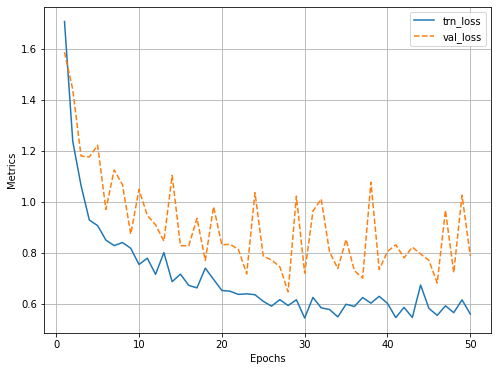

100%|██████████████████████████████████████| 151/151 [00:00<00:00, 20965.27it/s]


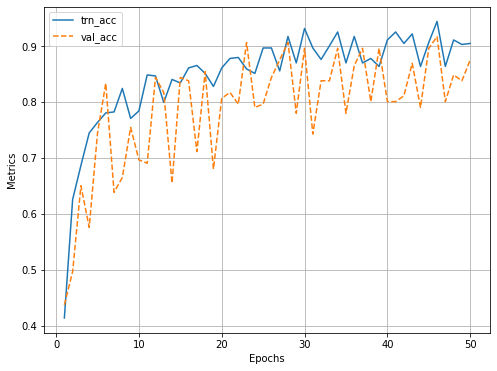

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [ ]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.689436 Acc: 0.858929


#### Note that the test results may vary a lot when you run this notebook several times.  

### Save the model

In [ ]:
# torch.save(model.to('cpu').state_dict(), model_name)